# Classification using Logistic Regression: Predicting Excessive Absenteeism 

First version completed: August 2019

Updated: August 2020

This notebook will use logistic regression to predict and classify cases of extreme absenteeism (defined as more than the median of the provided dataset). The notebook is split into the following sections:
1. Cleaning and preprocessing of the data
2. Modeling
3. Model Evaluation
4. Future work and suggested improvements

### Import libraries and adjust output settings

In [551]:
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             precision_recall_curve,
                             f1_score,
                             auc,
                             confusion_matrix,
                             plot_confusion_matrix) 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

In [552]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

### Import the data from a csv

In [553]:
raw_csv_data = pd.read_csv("Absenteeism-data.csv")
raw_csv_data.head()

,ID,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,11,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,36,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,3,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,11,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [554]:
# Create checkpoint
data = raw_csv_data.copy()

### Clean and Preprocess the Data

In [555]:
# Drop the ID column and check for missing values
data = data.drop(columns=["ID"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Reason for Absence         700 non-null    int64  
 1   Date                       700 non-null    object 
 2   Transportation Expense     700 non-null    int64  
 3   Distance to Work           700 non-null    int64  
 4   Age                        700 non-null    int64  
 5   Daily Work Load Average    700 non-null    float64
 6   Body Mass Index            700 non-null    int64  
 7   Education                  700 non-null    int64  
 8   Children                   700 non-null    int64  
 9   Pets                       700 non-null    int64  
 10  Absenteeism Time in Hours  700 non-null    int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 60.3+ KB


As can be seen from the above output, there are no missing values in this dataset. From here, I will move onto some feature engineering.

#### Feature Engineering: Reason for Absense Feature

In [563]:
print(f'The number of categories in the Reason for Absence feature is: {data["Reason for Absence"].nunique()}')

The number of categories in the Reason for Absence feature is: 28


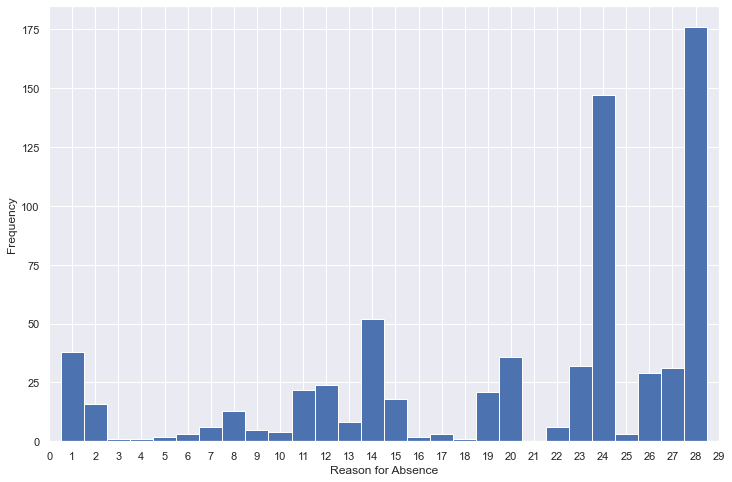

In [557]:
# visualise the distribution of the feature
fig, ax = plt.subplots(figsize=(12,8))
plt.hist(data["Reason for Absence"], bins=28, align="right");
plt.xlabel("Reason for Absence")
plt.ylabel ("Frequency")
loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)
plt.xlim([0,29]);

The Reason for Absence feature is a catagorical feature as the numbers have no mathematical relationship to each other. Therefore we need to create dummy variables (one-hot encoding).
It is important to have n-1 dummy variables for n categories as one level of the categorical feature becomes the reference group during dummy encoding and is redundant. In this case I will use the first column as the reference column. I will then also drop the Reason for Absence feature as I no longer require it in its original state.

In [564]:
reasons_columns = pd.get_dummies(data["Reason for Absence"], drop_first = True)
data = data.drop(["Reason for Absence"], axis =1)
data.head()

,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,23/07/2015,289,36,33,239.554,30,1,2,1,2


Since there are 27 dummy variables that have been created, I am going to group similar reasons together based on the below information:
 - Reasons 1-14: all related to diseases;
 - Reasons 15-17: all related to pregnancies and giving birth
 - Reasons: 18-21: all related to poisoning or signs not elsewhere catagorised
 - Reasons 22-28: considered light reasons for absence (physio appointments, doctor's consultation etc).

This ensures that we don't have too many features considering the size of the dataset (700 observations).


In [565]:
# Group the dummy variables to minimise the amount. Done qualitativly as per the above descriptions.
reason_type1 = reasons_columns.loc[:,1:14].max(axis =1)
reason_type2 = reasons_columns.loc[:,15:17].max(axis =1)
reason_type3 = reasons_columns.loc[:,18:21].max(axis =1)
reason_type4 = reasons_columns.loc[:,22:].max(axis =1)

In [567]:
# Add reason_type columns to end of dataframe
df = pd.concat([data, reason_type1, reason_type2, reason_type3, reason_type4], axis = 1)

In [568]:
# Rename the dummy varible columns
column_names = ['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']
df.columns = column_names

# Reorder the column names to put the reasons at the front.
column_names_reordered = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4','Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours']
df = df[column_names_reordered]

df.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,23/07/2015,289,36,33,239.554,30,1,2,1,2


#### Create a checkpoint

In [569]:
df_reason_mod = df.copy()

#### Preprocess the Date feature and create Month and Day features

In [570]:
# Change the Date feature to a datetime with a specific format
df_reason_mod['Date'] = pd.to_datetime(df_reason_mod['Date'], format = '%d/%m/%Y')

In [571]:
#Extract the month value from the Date
df_reason_mod["Month Value"] = df_reason_mod["Date"].dt.month

# Use a differnet method to extract the day by using the apply() method.
def date_to_weekday(date_value):
    return date_value.weekday()
df_reason_mod['Day of the week'] = df_reason_mod['Date'].apply(date_to_weekday)

# Drop the Date feature
df_reason_mod = df_reason_mod.drop(['Date'], axis = 1)

new_col_order = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4','Month Value',
       'Day of the week', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children', 
        'Pets', 'Absenteeism Time in Hours']
df_reason_mod = df_reason_mod[new_col_order]

df_reason_mod.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,1,2,1,2


#### Create a checkpoint

In [572]:
df_reason_date_mod = df_reason_mod.copy()

#### Feature Engineering: Education Feature

The Education feature is also categorical and needs to be changed into a dummy variable (one-hot encoding).

In [573]:
df_reason_date_mod['Education'].value_counts()

1    583
3     73
2     40
4      4
Name: Education, dtype: int64

Note the following mapping for the Education feature: 
 - 1 is high school 
 - 2 is graduate 
 - 3 is postgraduate 
 - 4 is master/doctor 
 
Since there are not a lot of observations in categories 2-4 and since these categories also relate to tertiary education levels, I will create 2 groups with high school as 0 and the remaining as 1.


In [574]:
edu_map = {1: 0, 
           2: 1, 
           3: 1, 
           4: 1}
df_reason_date_mod['Education'] = df_reason_date_mod['Education'].map(edu_map)

# Check the mapping to ensure it was successful.
df_reason_date_mod['Education'].value_counts()

0    583
1    117
Name: Education, dtype: int64

#### Create checkpoint

In [575]:
df_preprocessed = df_reason_date_mod.copy()

### Modeling

#### Create the targets

In [576]:
data_preprocessed = df_preprocessed.copy()

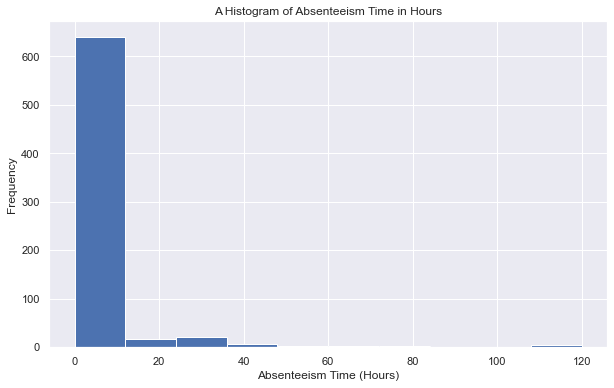

In [577]:
# Visualise the target to understand the distribution

fig, ax = plt.subplots(figsize=(10,6))
plt.hist(data_preprocessed["Absenteeism Time in Hours"]);
plt.xlabel("Absenteeism Time (Hours)")
plt.ylabel("Frequency")
plt.title("A Histogram of Absenteeism Time in Hours");

Since the target is provided in hours and I am using logistic regression (which is a classification algorithm), I therefore need to create classes. 
I am going to create 2 classes, one for moderately absent (0) and one for excessivly absent (1).
I will use the median value of the target, Absenteeism Time in Hours, and use it as a cutoff line. As can be seen from the distribution of the target above, the distribution has a long tail and is skewed to the right with significant outliers. It is therefore better to use the median of the distribution as a cutoff, rather than the mean for example.

In [578]:
print(f'The median of the target is: {data_preprocessed["Absenteeism Time in Hours"].median()}')

The median of the target is: 3.0


In [579]:
targets = np.where(data_preprocessed['Absenteeism Time in Hours'] > 
                   data_preprocessed["Absenteeism Time in Hours"].median() , 1, 0)

# Create target column where I will predict Excessive Absenteeism as defined as greater than the median of the data.
data_preprocessed['Excessive Absenteeism'] = targets

data_preprocessed.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Excessive Absenteeism
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4,1
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2,0
3,1,0,0,0,7,3,279,5,39,239.554,24,0,2,0,4,1
4,0,0,0,1,7,3,289,36,33,239.554,30,0,2,1,2,0


#### Check if the targets are balanced

When using classification algorithms, it is important to check if the dataset is balanced i.e. that there is a similar proportion of classes to each other. In general, a 45% - 55% split is allowed. If the dataset is unbalanced, there are methods that can be used to remedy this. For example, over-sampling, under-sampling and SMOTE can be used. Adjusting the decision threshold can also work, but the cost between false postives and false negatives must be understood and considered. 

In [580]:
print(f"The percentage of positive outcomes in the dataset is {targets.sum()/targets.shape[0]*100:.2f}%")

The percentage of positive outcomes in the dataset is 45.57%


Since the percentage of positive outcomes falls in the 45% - 55% interval, I will not adjust the balance of the dataset. I will also drop the feature Absenteeism Time in Hours as we are using Excessive Absenteeism as the target and Absenteeism Time in Hours cannot be used as a feature.

In [581]:
#Drop time in hours.
data_with_targets = data_preprocessed.drop(['Absenteeism Time in Hours'], axis = 1)

#### Select the inputs for the regression

In [582]:
# Select only the features/inputs and remove the target
unscaled_inputs = data_with_targets.iloc[:,0:-1]

#### Standardizing the data

Most algorithms expect the input data to be scaled at a minimum, if not normalised. This ensures that features with large magniudes do not have undue influence on the model as compared to features with small magnitudes. Logistic regression doesn't explicitly require standardisation/normalisation, however it can help the algorithm to converge.

Sklearn's StandardScaler() method does not easily allow specific columns to be normlised in a dataframe. As such, I will create my own custom scaler so that I can specify which columns I want to be scaled easily.

In [583]:
class CustomScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns, copy = True, with_mean = True, with_std = True):
        self.scaler = StandardScaler(copy=copy, with_mean=with_mean, with_std=with_std)
        self.columns = columns
        self.mean = None
        self.var = None
        
    def fit(self, X, y = None):
        self.scaler.fit(X[self.columns],y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    def transform(self, X, y = None, copy = None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns = self.columns)
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis = 1)[init_col_order]

In [584]:
# Omit dummies from list of columns that we want to scale
columns_to_omit = ["Reason_1", "Reason_2","Reason_3","Reason_4", "Education"]
columns_to_scale = [x for x in unscaled_inputs.columns.values if x not in columns_to_omit]

In [585]:
absenteeism_scaler = CustomScaler(columns_to_scale)
absenteeism_scaler.fit(unscaled_inputs)
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)
scaled_inputs.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month Value,Day of the week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets
0,0,0,0,1,0.182726,-0.683704,1.005844,0.412816,-0.536062,-0.806331,0.767431,0,0.880469,0.268487
1,0,0,0,0,0.182726,-0.683704,-1.574681,-1.141882,2.130803,-0.806331,1.002633,0,-0.019280,-0.589690
2,0,0,0,1,0.182726,-0.007725,-0.654143,1.426749,0.248310,-0.806331,1.002633,0,-0.919030,-0.589690
3,1,0,0,0,0.182726,0.668253,0.854936,-1.682647,0.405184,-0.806331,-0.643782,0,0.880469,-0.589690
4,0,0,0,1,0.182726,0.668253,1.005844,0.412816,-0.536062,-0.806331,0.767431,0,0.880469,0.268487


#### Shuffle and split data for training and testing

Shuffling the training data is important to ensure that the model does not learn relationships in the data that could only be a function of the order in which the data was collected. 

Splitting the data into training, validation and test sets is an excellent way to check if the model is overfitting and if it will generalise well on data that it has not seen before.

In [594]:
X = scaled_inputs
y = data_preprocessed["Excessive Absenteeism"]
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, 
                                                    targets,
                                                    train_size = 0.8,
                                                    shuffle = True,
                                                    random_state = 20)

#### Logistic Regression with sklearn

In [595]:
# Train the model
reg = LogisticRegression()
reg.fit(x_train, y_train)

# Determine the accuracy of the model on the training set
print(f"The training accuracy is: {reg.score(x_train, y_train)*100:.2f}%")
print(f"The test accuracy is: {reg.score(x_test, y_test)*100:.2f}%")

The training accuracy is: 77.50%
The test accuracy is: 74.29%


The difference between the training accuracy and test accuracy does not decrease substantially showing that the model is not overfitting the data and could probably generalise quite well. However, this is not a good enough evaluation of a model. As such, the following sections will be looking at cross-validation and various model evaluation methods to try and give a full picture of the performance of the model.

### Cross Validation

Cross-validation is an important model evaluation technique and allows the user to assess the effectivness of the model and it's predictive capability. It is important to ensure that you have the same proportion of the dataset in each fold to ensure that the folds are representative of the full dataset. This is of course, very imporant for classification problems. The way to ensure this is called stratified cross-validation. The benefits of cross-validation are detailed below:

 - For small datasets, it is very useful as all the data is used to train the model and you don't have to keep a section of your dataset aside exclusivly for testing;
 - Since multiple models are created, we have access to multiple metrics. This allows for an increase in confidence with regards to the performance of the model.

Average training accuracy: 76.86%. Average test accuracy: 72.57%
Average training roc_auc: 82.84%. Average test roc_auc: 77.33%


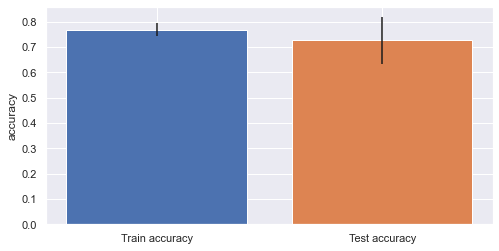

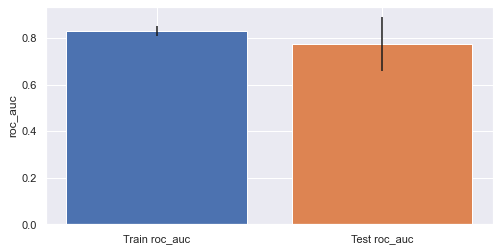

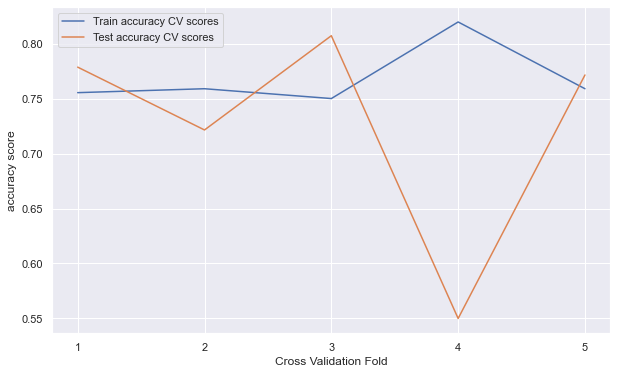

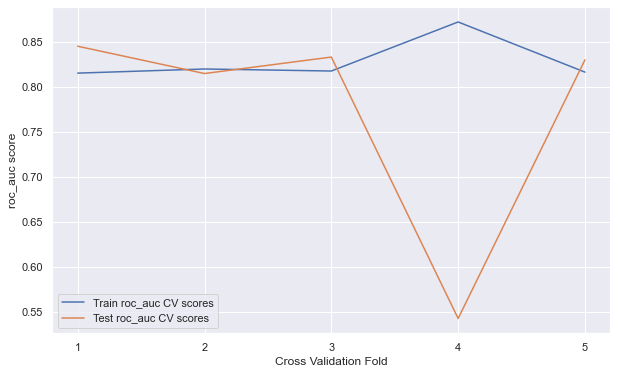

In [602]:
# Specify metrics to be used when evaluating the model during cross-validation
scoring_metrics = ('accuracy', 'roc_auc')

# Perform cross-validation
# Note: by specifying cv=5, StratifiedKFold is used automatically to ensure the folds have the same class proportion.
cv = 5
scores = cross_validate(reg,
                        X,
                        y,
                        cv=cv,
                        scoring=scoring_metrics,
                        return_train_score=True)

for score in scoring_metrics:
    plot_average_cv_scores(scores, score)
    
for score in scoring_metrics:
    plot_cv_score(scores, score)    

In [601]:
def plot_average_cv_scores(scores, scoring_metric):
    """ Plots the average training score and average test score over cross-validation
        fold.
        
        :param dict scores:
            A dictionary that is the output of sklearn's cross-validate method.
        :param str scoring_metric:
            A string specifying the scoring metric to plot from the scores dictionary.
        
        :returns figure:
            A figure with the average training score and average test score, as
            well as error bars showing the standard deviation.
    """
    fig, ax = plt.subplots(figsize=(8,4))
    train_mean = scores["train_"+score].mean()
    test_mean = scores["test_"+score].mean()
    plt.bar("Train "+scoring_metric, train_mean , yerr= scores["train_"+scoring_metric].std())
    plt.bar("Test "+scoring_metric, test_mean , yerr=scores["test_"+scoring_metric].std())
    plt.ylabel(score)
    print (f"Average training {score}: {train_mean*100:.2f}%. Average test {score}: {test_mean*100:.2f}%")

In [418]:
def plot_cv_score(scores, scoring_metric):
    """ Plots the training score and test score for a specified metric for
        each cross-validation fold.
        
        :param dict scores:
            A dictionary that is the output of sklearn's cross-validate method.
        :param str scoring_metric:
            A string specifying the scoring metric to plot from the scores dictionary.
        
        :returns figure:
            A figure with the cross-validation fold on the x-axis and the score on 
            the y-axis.
    """
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(np.arange(cv)+1, scores["train_"+scoring_metric], label=f"Train {scoring_metric} CV scores")
    plt.plot(np.arange(cv)+1, scores["test_"+scoring_metric], label=f"Test {scoring_metric} CV scores")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.xlabel("Cross Validation Fold")
    plt.ylabel(f"{scoring_metric} score")

The above 2 plots show that training on the third fold caused overfitting. This is shown by having high training scores but much lower testing scores on this fold. This is also apparent in both metrics. The rest of the folds have much closer training and testing scores indicating that the model would be more robust if trained on this data. The error bars in the bar plots also show that the scores on the test data have a high standard deviation; this is to be expected, however it should be noted that the model is probably not as robust as it could be and we may not see close to training-level performance on unseen data.

### Model Evaluation

#### Plot the ROC Curve and Calculate ROC AUC

Training Set: ROC AUC=82.47%
Test Set: ROC AUC=79.24%


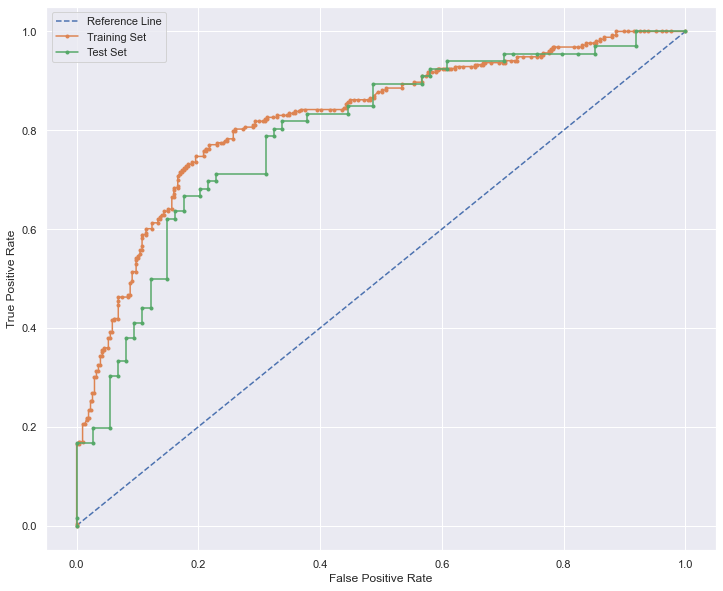

In [607]:
plot_roc_curve(reg, x_train, y_train, x_test, y_test)

The ROC curve plots the False Positive Rate against the True Positive Rate at various decision thesholds. The perfect model would only have a point at (0,1).

The above ROC curve shows that model is better than a model with no skill at all (equivalent to guessing randomly) as the curves are bent towards the point (0,1) and are significantly above the blue dotted reference line. The test set curve and ROC AUC is expected to be lower than the training set curve and the small difference between and curves and the ROC AUC informs us that the model is not overfitting very much and will most likely generalise to data that it has not seen before.

The ROC AUC is the area under the ROC curve and represents the likelihood that the classifier model will rank a randomly chosen postive instance higher than a randomly chosen negative instance. A ROC AUC of 0.5 and lower is a useless classifier and ROC AUC scores are often used for comparing different classifiers (with the higher value the better) and can be thought of as a summary of model skill.

#### Plot the precesion-recall curve; calculate F1 scores and the AUC

Training: F1 score=0.746 AUC=0.808
Test:     F1 score=0.719 AUC=0.772


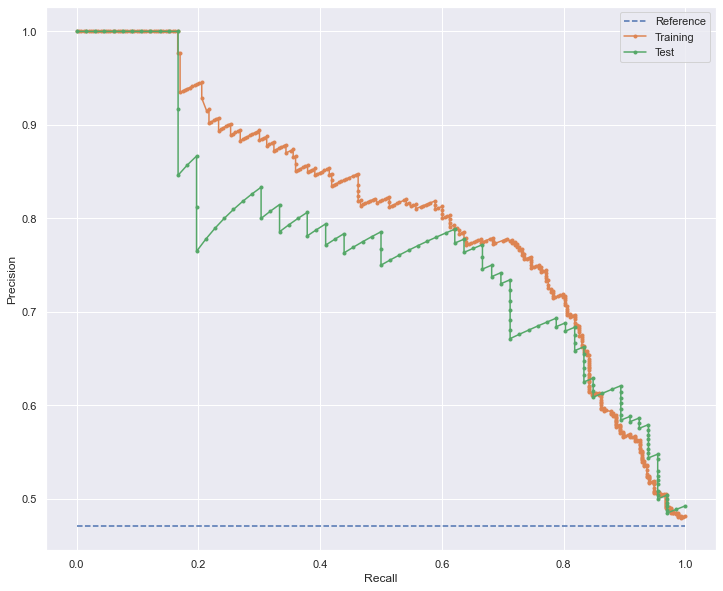

In [608]:
plot_prec_recall_curve(reg, x_train, y_train, x_test, y_test)

The precision-recall curve is a plot of the recall on the x-axis and the precision on the y-axis at different thresholds. Recall is the ratio of true positives divided by the sum of true positives and false negatives and shows the proportion of correct positive predictions out of all the actual positive predictions. It shows how good the model is at predicting the positive class when the actual outcome is postive. Precision is the ratio of true positives to the sum of true positives and false positives and shows how good the model is at predicting the positive class. 

Precision-recall curves are useful for binary classifiers when you have a moderate to large imbalanced dataset. The reference curve is plotted at the ratio of the positive class to the negative class (in this case 45%). A perfect model will be a point at (1,1) and a skilled model's curve will be bent towards (1,1). For model selection, the F1 score (harmonic mean of precision and recall) summarises the model skill for a specific probability threshold (e.g. 0.5) but the AUC in this case shows the model skill at various thresholds.

In this case, our dataset is fairly balanced and we would expect to see simialr results between the ROC curve and precision-recall curve. The precision-recall curve confirms that the model is skilled at predicting the postive class as well as the negative class.

In [609]:
def plot_roc_curve(model, x_train, y_train, x_test, y_test):
    """ Returns a ROC curve for both the training and test set along with the
        ROC AUC scores for the training and test set.
        
        :param sklearn estimator model:
            A trained model.
        :params pandas.DataFrame x_train, y_train, x_test, y_test:
            The dataframes that are used to train the model.
        
        :returns figure:
            Returns a figure showing the false positive rate versus the true
            positive rate along with the ROC AUC scores for the train and test
            sets.
    """
    ref_probs = [0 for _ in range(len(y_test))]
    probs_train = reg.predict_proba(x_train)[:,1]
    probs_test = reg.predict_proba(x_test)[:,1]
    ref_auc = roc_auc_score(y_test, ref_probs)
    auc_train = roc_auc_score(y_train, probs_train)
    auc_test = roc_auc_score(y_test, probs_test)
    print(f"Training Set: ROC AUC={auc_train*100:.2f}%")
    print(f"Test Set: ROC AUC={auc_test*100:.2f}%")
    ref_fpr, ref_tpr, _ = roc_curve(y_test, ref_probs)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
    fig, ax = plt.subplots(figsize=(12,10))
    plt.plot(ref_fpr, ref_tpr, linestyle='--', label='Reference Line')
    plt.plot(fpr_train, tpr_train, marker='.', label='Training Set')
    plt.plot(fpr_test, tpr_test, marker='.', label='Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [610]:
def plot_prec_recall_curve(model, x_train, y_train, x_test, y_test):
    """ Returns a precision-recall curve for both the training and test 
        set along with the F1 scores and AUC for the training and test set.
        
        :param sklearn estimator model:
            A trained model.
        :params pandas.DataFrame x_train, y_train, x_test, y_test:
            The dataframes that are used to train the model.
        
        :returns figure:
            Returns a figure showing recall (x axis) and precision (y axis)
            along with the F1 scores and AUC for the train and test sets.
    """
    train_probs = model.predict_proba(x_train)[:, 1]
    test_probs = model.predict_proba(x_test)[:, 1]
    yhat_train = model.predict(x_train)
    yhat_test = model.predict(x_test)
    train_precision, train_recall, _ = precision_recall_curve(y_train, train_probs)
    test_precision, test_recall, _ = precision_recall_curve(y_test, test_probs)
    train_f1, train_auc = f1_score(y_train, yhat_train), auc(train_recall, train_precision)
    test_f1, test_auc = f1_score(y_test, yhat_test), auc(test_recall, test_precision)
    print('Training: F1 score=%.3f AUC=%.3f' % (train_f1, train_auc))
    print('Test:     F1 score=%.3f AUC=%.3f' % (test_f1, test_auc))
    ref = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots(figsize=(12,10))
    plt.plot([0, 1], [ref, ref], linestyle='--', label='Reference')
    plt.plot(train_recall, train_precision, marker='.', label='Training')
    plt.plot(test_recall, test_precision, marker='.', label='Test')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

#### Feature and Permutation Importance

Permutation importance is a good method for understanding which featues contribute most to the model score. It is calculated by calculating a model score, and then for each feature, randomly shuffling the feature, recalculating the score and calculating the difference between scores.

In [611]:
perm = PermutationImportance(reg, random_state=0).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.1664 ± 0.0448,Reason_1
0.0764 ± 0.0165,Reason_3
0.0704 ± 0.0029,Transportation Expense
0.0446 ± 0.0206,Children
0.0239 ± 0.0062,Reason_4
0.0171 ± 0.0173,Body Mass Index
0.0157 ± 0.0091,Age
0.0104 ± 0.0116,Pets
0.0050 ± 0.0027,Reason_2
0.0011 ± 0.0058,Month Value


As can be seen from the above output, Reason_1, Reason_3 and Transportation Expense are the three top features that contribute to the model score according to permutation importance. Distance to Work, Education and Day of hte week actually detract from the model score and a next step could be to remove these features from the model.

Below I have created my own Permutation Importance function with scoring as an input so that the scoring metric can be changed.

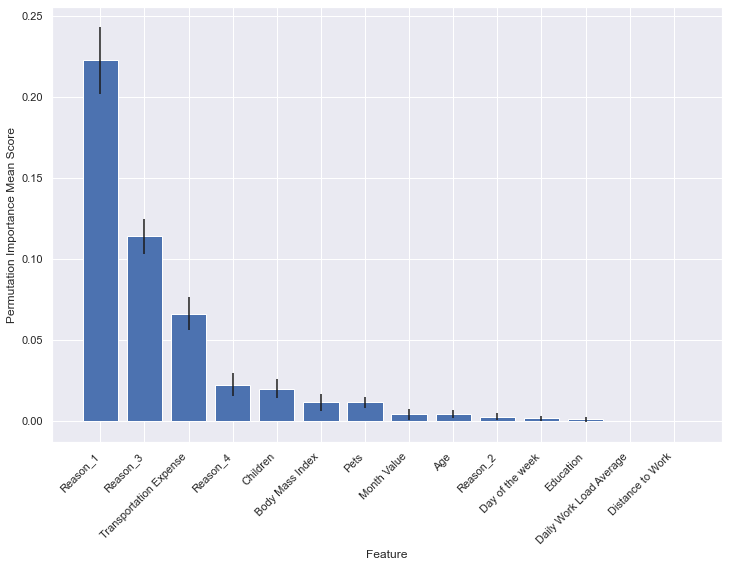

In [612]:
plot_permutation_importance(reg, x_train, y_train, scoring="roc_auc", n_repeats=30, random_state=0)

Using two different metrics to understand the permutation importance gives us more information with regards to which features are important. The same features are shown to be both useful and not useful when plotting the permutation importance with a different metric as compared to the eli5 implementation above.

In [613]:
def plot_permutation_importance(model, X, y, scoring, n_repeats, random_state):
    """ Returns a plot of the features on the x-axis and their corresponding
        mean permutation importance scores on the y-axis in descending order.
        
        :param estimator model:
            An sklearn trained model.
        :param pandas.DataFrame X:
            A pandas dataframe containing the features used to train the model.
        :param pandas.Series y:
            A pandas series containing the targets for the model.
        :param str scoring:
            The scoring method used to calculated the permutation importance
            scores.
        :param int n_repeats:
            The numer of time to run the permutation importance function to 
            calculate the mean score and standard deviation.
        :param int random_state:
            The random state to ensure replicability where required.
            
        :returns figure:
            A matplotlib figure is returned.
    """
    results = permutation_importance(model, X, y, scoring=scoring, n_repeats=n_repeats, random_state=random_state)
    importance = results.importances_mean
    error = results.importances_std
    df = pd.DataFrame({"features": scaled_inputs.columns,
                             "importances": importance,
                      "error": error})
    df = df.sort_values(by="importances", ascending=False)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.bar(df["features"], df["importances"], yerr = df["error"])
    plt.xticks(rotation=45)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    plt.xlabel("Feature")
    plt.ylabel("Permutation Importance Mean Score")
    plt.show()

#### Confusion Matrices

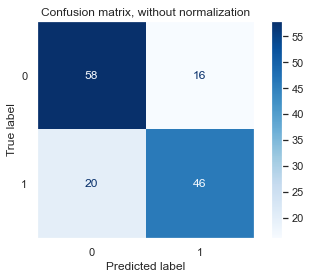

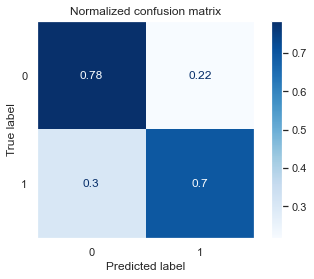

In [614]:
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(reg, x_test, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.grid(None)
plt.show();

Confusion matrices give a more nuanced understanding of the accuracy of the model. Normalised confusion matrices ensure that the rows sum to one to allow for an understanding of the distribution of model predictions. For example, for the actual outcomes of moderate absenteeism (target label 0), 78% of predictions were correct whilst 22% were incorrect (predicting excessive absenteeism when in fact it was moderate absenteeism - false positives). For the actual outcomes of excessive absenteeism (target label 1), 70% were correctly predicted and 30% incorrectly predicted (false negatives). The cost of false negatives vs false positives must be understood in the business case; for example, is it worse to predict a false positive than a false negative? To guarentee the decrease in the number of false postives, one could increase the decision theshold up from 50% - however this could increase the number of false negatives and vice versa.

### Analysis of the intercept and the coefficients

In [615]:
# Display a dataframe of the intercept and coefficients of the model

feature_names = np.append('Intercept', unscaled_inputs.columns.values)
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_names)
coeffs = np.append(reg.intercept_, reg.coef_)
summary_table['Coefficient'] = coeffs
summary_table

,Feature name,Coefficient
0,Intercept,-1.656109
1,Reason_1,2.800965
2,Reason_2,0.934858
3,Reason_3,3.095616
4,Reason_4,0.856587
5,Month Value,0.166248
6,Day of the week,-0.084370
7,Transportation Expense,0.612733
8,Distance to Work,-0.007797
9,Age,-0.165923


#### Interpreting the Coefficients

Because we standardised the inputs before we trained the model, understanding the impact of the coeffients becomes much more simple. In this case, larger coefficients in magnitude have larger impacts on the model. It also should be understood that when doing logistic regression, the log odds are predicted and as such, the coeffients are related to predicting the log odds; therefore to interpret the coefficients, take the exponential. Coefficients close to 0 or odds ratios close to one indicate that a feature does not have an impact on the model.

In [616]:
summary_table['Odds_ratio'] = np.exp(summary_table['Coefficient'])
summary_table.sort_values('Odds_ratio', ascending = False)

,Feature name,Coefficient,Odds_ratio
3,Reason_3,3.095616,22.100858
1,Reason_1,2.800965,16.460523
2,Reason_2,0.934858,2.546851
4,Reason_4,0.856587,2.355110
7,Transportation Expense,0.612733,1.845467
13,Children,0.361990,1.436184
11,Body Mass Index,0.271811,1.312340
5,Month Value,0.166248,1.180866
10,Daily Work Load Average,-0.000147,0.999853
8,Distance to Work,-0.007797,0.992233


As can be seen from the table, the features Daily Work Load Average and Distance to Work have coefficients close to 0 and odds ratios close to one indicating that they do not add predictive power to the model. They could be dropped in a second iteration of the model.

### Suggested Future Work

In the next iterations of the model, I would suggest removing features that do not seem to be adding value to the model as suggested above. This would simplify the model.

The plot_permutation_importance() function could be extended to allow for cross-validation scores rather than only using the training set. This is also true for plot_roc_curve() and plot_prec_recall_curve() functions.

Other models could also be explored in an attempt to increase the accuracy of the model. For example, random forests could be used.